# Project 5: Final Integrated System
## NFL Player Trajectory Prediction - Unified ML Pipeline

**Authors:** Jorge Aparicio, Ignacio Calvo, and Gian Maria Troiani  
**Course:** CAI4510C Machine Learning Capstone  
**Date:** December 2025

---

### Project Integration Summary

| Step | Source | Component | Description |
|------|--------|-----------|-------------|
| 1 | P5 | Setup | Configuration, imports, utilities |
| 2 | P5 | Data | Loading, feature engineering, sequence construction |
| 3 | P1-P2 | Classical ML | Decision Tree, Random Forest, SMOTE |
| 4 | P3 | Neural Network | MLP with MC Dropout |
| 5 | P4 | Sequential | LSTM Encoder-Decoder, Transformer |
| 6 | P5 | Generative | VAE-style data augmentation |
| 7 | P5 | MLOps | Run logging, model cards, ethics |
| 8 | P5 | Graph | Link prediction (Common Neighbors, Jaccard, Adamic-Adar) |
| 9 | P5 | Reinforcement Learning | Q-Learning with dynamic ball-landing rewards |
| 10 | P5 | Results | Summary, comparison, report generation |


---
## Step 1: Setup & Configuration
**Source:** Project 5 (New)  
**Component:** Environment Setup  
**Purpose:** Import libraries, set seeds, define configuration and utility classes


In [1]:
# =============================================================================
# STEP 1: SETUP & CONFIGURATION
# Source: Project 5 (New)
# Component: Environment Setup
# Purpose: Import all required libraries and set global configuration
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import json
import hashlib
import time
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Classical ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix)

# SMOTE for class imbalance
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imbalanced-learn not installed. Run: pip install imbalanced-learn")

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"SMOTE available: {SMOTE_AVAILABLE}")


Setup complete!
PyTorch version: 2.9.0+cu126
CUDA available: True
SMOTE available: True


In [2]:
# =============================================================================
# STEP 1.2: GLOBAL CONFIGURATION
# Source: Project 5 (New)
# Component: Configuration Management
# Purpose: Centralized hyperparameters for all models
# =============================================================================

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

CONFIG = {
    # Paths
    'data_path': 'input_2023_w18.csv',
    'output_dir': 'outputs_project5',

    # Reproducibility
    'seed': SEED,

    # Data splits
    'test_size': 0.20,
    'val_size': 0.15,

    # Sequence parameters (from Project 4)
    'input_seq_len': 20,
    'output_seq_len': 5,

    # Classification threshold
    'catch_radius': 6.0,

    # ---------- PROJECT 1-2: Classical ML ----------
    'classical': {
        'models': ['LogisticRegression', 'DecisionTree', 'RandomForest'],
        'use_smote': True,
        'rf_n_estimators': 100,
        'rf_max_depth': 10
    },

    # ---------- PROJECT 3: Neural Network (MLP) ----------
    'mlp': {
        'hidden_sizes': [128, 64],
        'dropout': 0.3,
        'epochs': 50,
        'batch_size': 32,
        'lr': 0.001,
        'mc_samples': 10  # MC Dropout samples for uncertainty
    },

    # ---------- PROJECT 4: LSTM ----------
    'lstm': {
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.2,
        'epochs': 30,
        'batch_size': 16,
        'lr': 0.001,
        'teacher_forcing_ratio': 0.5
    },

    # ---------- PROJECT 4: Transformer ----------
    'transformer': {
        'd_model': 64,
        'nhead': 4,
        'num_layers': 2,
        'dim_feedforward': 256,
        'dropout': 0.1,
        'epochs': 30,
        'batch_size': 16,
        'lr': 0.001
    },

    # ---------- PROJECT 5: Generative (VAE-style) ----------
    'generative': {
        'latent_dim': 8,
        'augment_ratios': [0.0, 0.10, 0.25]
    },

    # ---------- PROJECT 5: Graph Link Prediction ----------
    'graph': {
        'test_ratio': 0.2,
        'k_values': [3, 5, 10]
    },

    # ---------- PROJECT 5: Reinforcement Learning ----------
    'rl': {
        'grid_size': 10,  # 10x10 grid for finer resolution
        'gamma': 0.95,
        'alpha': 0.2,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay': 0.995,
        'episodes': 500,
        'max_steps': 50
    }
}

# Create output directories
os.makedirs(CONFIG['output_dir'], exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/artifacts", exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/models", exist_ok=True)
os.makedirs(f"{CONFIG['output_dir']}/model_cards", exist_ok=True)

print("Configuration loaded:")
for key, value in CONFIG.items():
    if isinstance(value, dict):
        print(f"  {key}: {len(value)} parameters")
    else:
        print(f"  {key}: {value}")


Configuration loaded:
  data_path: input_2023_w18.csv
  output_dir: outputs_project5
  seed: 42
  test_size: 0.2
  val_size: 0.15
  input_seq_len: 20
  output_seq_len: 5
  catch_radius: 6.0
  classical: 4 parameters
  mlp: 6 parameters
  lstm: 7 parameters
  transformer: 8 parameters
  generative: 2 parameters
  graph: 2 parameters
  rl: 8 parameters


In [3]:
# =============================================================================
# STEP 1.3: UTILITY CLASSES
# Source: Project 5 (New)
# Component: MLOps Infrastructure
# Purpose: Logging, timing, and reproducibility utilities
# =============================================================================

class Timer:
    """Context manager for timing code blocks."""
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.elapsed = time.perf_counter() - self.start
        self.elapsed_ms = self.elapsed * 1000

class RunLogger:
    """
    MLOps run logger - appends experiment metrics to CSV.
    Schema: run_id, timestamp, git_commit, data_hash, config_hash, seed,
            component, metric_name, metric_value, latency_ms, params_json, notes
    """

    def __init__(self, log_path, data_path=None, config=None):
        self.log_path = log_path
        self.run_id = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.data_hash = self._hash_file(data_path) if data_path else 'N/A'
        self.config_hash = self._hash_dict(config) if config else 'N/A'

        # Initialize CSV if not exists
        if not os.path.exists(log_path):
            with open(log_path, 'w') as f:
                f.write('run_id,timestamp,git_commit,data_hash,config_hash,seed,'
                       'component,metric_name,metric_value,latency_ms,params_json,notes\n')

    def _hash_file(self, path):
        if not os.path.exists(path):
            return 'file_not_found'
        h = hashlib.sha256()
        with open(path, 'rb') as f:
            h.update(f.read()[:10000])  # Hash first 10KB
        return h.hexdigest()[:16]

    def _hash_dict(self, d):
        return hashlib.sha256(json.dumps(d, sort_keys=True, default=str).encode()).hexdigest()[:16]

    def log(self, component, metric_name, metric_value, latency_ms=0, params=None, notes=''):
        row = {
            'run_id': self.run_id,
            'timestamp': datetime.now().isoformat(),
            'git_commit': 'notebook',
            'data_hash': self.data_hash,
            'config_hash': self.config_hash,
            'seed': SEED,
            'component': component,
            'metric_name': metric_name,
            'metric_value': f'{metric_value:.6f}' if isinstance(metric_value, float) else metric_value,
            'latency_ms': f'{latency_ms:.2f}',
            'params_json': json.dumps(params)[:200] if params else '{}',
            'notes': notes
        }
        with open(self.log_path, 'a') as f:
            f.write(','.join(str(row[k]) for k in ['run_id','timestamp','git_commit','data_hash',
                    'config_hash','seed','component','metric_name','metric_value','latency_ms',
                    'params_json','notes']) + '\n')

def log(msg):
    """Simple timestamped logging."""
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

# Initialize run logger
RUN_LOGGER = RunLogger(
    f"{CONFIG['output_dir']}/run_log.csv",
    CONFIG['data_path'],
    CONFIG
)

log("Utilities initialized")
print(f"Run ID: {RUN_LOGGER.run_id}")
print(f"Data hash: {RUN_LOGGER.data_hash}")


[20:18:17] Utilities initialized
Run ID: 20251203_201817
Data hash: f982a02762789876


---
## Step 2: Data Loading & Feature Engineering
**Source:** Project 5 (builds on Projects 1-4)  
**Component:** Data Pipeline  
**Purpose:** Load NFL tracking data, engineer features, construct sequences for all models


In [4]:
# =============================================================================
# STEP 2.1: LOAD RAW DATA
# Source: Project 5 (Data Pipeline)
# Component: Data Loading
# Purpose: Load NFL Big Data Bowl tracking data
# =============================================================================

log("Loading data...")

df = pd.read_csv(CONFIG['data_path'])

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


[20:18:17] Loading data...

Dataset shape: (78021, 23)
Columns: ['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']

First few rows:


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2024010600,77,False,45395,1,left,83,Arthur Maulet,5-10,190,...,Defensive Coverage,80.56,30.48,1.79,0.83,356.85,76.40,10,88.459999,42.700001
1,2024010600,77,False,45395,2,left,83,Arthur Maulet,5-10,190,...,Defensive Coverage,80.54,30.66,1.75,0.95,353.08,77.45,10,88.459999,42.700001
2,2024010600,77,False,45395,3,left,83,Arthur Maulet,5-10,190,...,Defensive Coverage,80.51,30.83,1.74,1.19,347.95,80.41,10,88.459999,42.700001
3,2024010600,77,False,45395,4,left,83,Arthur Maulet,5-10,190,...,Defensive Coverage,80.47,31.00,1.73,1.30,342.59,82.75,10,88.459999,42.700001
4,2024010600,77,False,45395,5,left,83,Arthur Maulet,5-10,190,...,Defensive Coverage,80.41,31.16,1.72,1.52,336.20,82.75,10,88.459999,42.700001


In [5]:
# =============================================================================
# STEP 2.2: FEATURE ENGINEERING
# Source: Projects 1-2 (Feature Engineering)
# Component: Feature Creation
# Purpose: Create derived features (velocity components, acceleration components)
# =============================================================================

log("Engineering features...")

# Define feature sets
NUMERICAL_FEATURES = ['x', 'y', 's', 'a', 'dir', 'o', 's_x', 's_y', 'a_x', 'a_y',
                      'ball_land_x', 'ball_land_y']

# Create derived features
df['dir_rad'] = np.deg2rad(df['dir'])
df['s_x'] = df['s'] * np.cos(df['dir_rad'])
df['s_y'] = df['s'] * np.sin(df['dir_rad'])
df['a_x'] = df['a'] * np.cos(df['dir_rad'])
df['a_y'] = df['a'] * np.sin(df['dir_rad'])

# Create classification target: within CATCH_RADIUS yards of ball landing
CATCH_RADIUS = CONFIG['catch_radius']
df['dist_to_ball'] = np.sqrt((df['x'] - df['ball_land_x'])**2 +
                              (df['y'] - df['ball_land_y'])**2)
df['within_catch_radius'] = (df['dist_to_ball'] <= CATCH_RADIUS).astype(int)

print(f"Features created: {NUMERICAL_FEATURES}")
print(f"\nClass distribution (within {CATCH_RADIUS} yards):")
print(df['within_catch_radius'].value_counts(normalize=True))


[20:18:17] Engineering features...
Features created: ['x', 'y', 's', 'a', 'dir', 'o', 's_x', 's_y', 'a_x', 'a_y', 'ball_land_x', 'ball_land_y']

Class distribution (within 6.0 yards):
within_catch_radius
0    0.916638
1    0.083362
Name: proportion, dtype: float64


In [6]:
# =============================================================================
# STEP 2.3: SEQUENCE CONSTRUCTION
# Source: Project 4 (Sequential Data)
# Component: Sequence Builder
# Purpose: Create input/output sequences for LSTM and Transformer models
# =============================================================================

log("Constructing sequences...")

INPUT_SEQ_LEN = CONFIG['input_seq_len']
OUTPUT_SEQ_LEN = CONFIG['output_seq_len']
TOTAL_SEQ_LEN = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN

# Group by play and filter for target players
df['play_key'] = df['game_id'].astype(str) + '_' + df['play_id'].astype(str)

sequences = []
metadata = []

for play_key, group in df.groupby('play_key'):
    # Filter for prediction target players
    target_players = group[group['player_to_predict'] == True] if 'player_to_predict' in group.columns else group

    for player_id, player_data in target_players.groupby('nfl_id') if 'nfl_id' in target_players.columns else [(0, target_players)]:
        player_data = player_data.sort_values('frame_id' if 'frame_id' in player_data.columns else 'frame')

        if len(player_data) >= TOTAL_SEQ_LEN:
            # Extract features
            features = player_data[NUMERICAL_FEATURES].values[:TOTAL_SEQ_LEN]

            # Input: first INPUT_SEQ_LEN frames
            X_seq = features[:INPUT_SEQ_LEN]

            # Output trajectory: next OUTPUT_SEQ_LEN frames (x, y only)
            Y_traj = features[INPUT_SEQ_LEN:, :2]  # x, y positions

            # Classification label: final frame within catch radius
            final_dist = player_data.iloc[TOTAL_SEQ_LEN - 1]['dist_to_ball']
            Y_class = int(final_dist <= CATCH_RADIUS)

            # Ball landing position for this play
            ball_land_x = player_data.iloc[0]['ball_land_x']
            ball_land_y = player_data.iloc[0]['ball_land_y']

            sequences.append({
                'X': X_seq,
                'Y_traj': Y_traj,
                'Y_class': Y_class,
                'ball_land_x': ball_land_x,
                'ball_land_y': ball_land_y
            })

            metadata.append({
                'play_key': play_key,
                'player_position': player_data.iloc[0].get('player_position', 'UNK'),
                'ball_land_x': ball_land_x,
                'ball_land_y': ball_land_y
            })

print(f"\nTotal sequences: {len(sequences)}")
print(f"Input shape: ({INPUT_SEQ_LEN}, {len(NUMERICAL_FEATURES)})")
print(f"Output trajectory shape: ({OUTPUT_SEQ_LEN}, 2)")
print(f"Class distribution: {np.mean([s['Y_class'] for s in sequences]):.1%} positive")


[20:18:17] Constructing sequences...

Total sequences: 452
Input shape: (20, 12)
Output trajectory shape: (5, 2)
Class distribution: 19.2% positive


In [7]:
# =============================================================================
# STEP 2.4: TRAIN/VAL/TEST SPLIT
# Source: Projects 1-4 (Standard Practice)
# Component: Data Splitting
# Purpose: Stratified split maintaining class balance
# =============================================================================

log("Splitting data...")

# Convert to arrays
X_seq = np.array([s['X'] for s in sequences])
Y_traj = np.array([s['Y_traj'] for s in sequences])
Y_class = np.array([s['Y_class'] for s in sequences])
ball_lands = np.array([[s['ball_land_x'], s['ball_land_y']] for s in sequences])

# Stratified split
X_temp, X_test, Y_traj_temp, Y_traj_test, Y_class_temp, Y_class_test, meta_temp, meta_test, ball_temp, ball_test = \
    train_test_split(X_seq, Y_traj, Y_class, metadata, ball_lands,
                     test_size=CONFIG['test_size'], random_state=SEED, stratify=Y_class)

val_ratio = CONFIG['val_size'] / (1 - CONFIG['test_size'])
X_train, X_val, Y_traj_train, Y_traj_val, Y_class_train, Y_class_val, meta_train, meta_val, ball_train, ball_val = \
    train_test_split(X_temp, Y_traj_temp, Y_class_temp, meta_temp, ball_temp,
                     test_size=val_ratio, random_state=SEED, stratify=Y_class_temp)

# Normalize features
scaler = StandardScaler()
n_train, seq_len, n_features = X_train.shape
X_train_flat = X_train.reshape(-1, n_features)
scaler.fit(X_train_flat)

X_train_scaled = scaler.transform(X_train.reshape(-1, n_features)).reshape(n_train, seq_len, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(len(X_val), seq_len, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(len(X_test), seq_len, n_features)

# First-frame features for classical ML
X_train_classical = X_train_scaled[:, 0, :]
X_val_classical = X_val_scaled[:, 0, :]
X_test_classical = X_test_scaled[:, 0, :]

print(f"\nData splits:")
print(f"  Train: {len(X_train)} ({Y_class_train.mean():.1%} positive)")
print(f"  Val:   {len(X_val)} ({Y_class_val.mean():.1%} positive)")
print(f"  Test:  {len(X_test)} ({Y_class_test.mean():.1%} positive)")

# Log data preparation
RUN_LOGGER.log('data_prep', 'n_sequences', len(sequences), notes='total')
RUN_LOGGER.log('data_prep', 'n_train', len(X_train), notes='train_split')
RUN_LOGGER.log('data_prep', 'n_val', len(X_val), notes='val_split')
RUN_LOGGER.log('data_prep', 'n_test', len(X_test), notes='test_split')
RUN_LOGGER.log('data_prep', 'positive_rate', Y_class_train.mean(), notes='class_balance')


[20:18:18] Splitting data...

Data splits:
  Train: 293 (19.1% positive)
  Val:   68 (19.1% positive)
  Test:  91 (19.8% positive)


---
## Step 3: Classical Machine Learning
**Source:** Projects 1-2  
**Component:** Classical ML Classifiers  
**Models:** Logistic Regression, Decision Tree, Random Forest  
**Technique:** SMOTE for class imbalance handling


In [8]:
# =============================================================================
# STEP 3.1: CLASSICAL ML ADAPTER
# Source: Projects 1-2 (Classical ML)
# Component: Model Adapter Interface
# Purpose: Unified interface for classical sklearn models
# =============================================================================

class ClassicalMLAdapter:
    """
    Adapter for classical ML models (from Projects 1-2).
    Provides consistent fit/predict/predict_proba interface.
    Supports SMOTE for class imbalance.
    """

    def __init__(self, model, use_smote=False):
        self.model = model
        self.use_smote = use_smote and SMOTE_AVAILABLE
        self.smote = SMOTE(random_state=SEED) if self.use_smote else None

    def fit(self, X, y):
        if self.use_smote:
            X_resampled, y_resampled = self.smote.fit_resample(X, y)
            self.model.fit(X_resampled, y_resampled)
        else:
            self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        if hasattr(self.model, 'predict_proba'):
            return self.model.predict_proba(X)[:, 1]
        return self.predict(X).astype(float)

    def get_params(self):
        return self.model.get_params()

log("ClassicalMLAdapter defined")


[20:18:18] ClassicalMLAdapter defined


In [9]:
# =============================================================================
# STEP 3.2: TRAIN CLASSICAL MODELS
# Source: Projects 1-2 (Classical ML)
# Component: Model Training
# Models: Logistic Regression, Decision Tree, Random Forest
# EXACT MATCH to Project 2: Uses class_weight='balanced' and random_state=42
# =============================================================================

log("Training classical ML models...")

# Exact model definitions from Project 2
classical_models = {
    'LogisticRegression': ClassicalMLAdapter(
        LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        use_smote=CONFIG['classical']['use_smote']
    ),
    'DecisionTree': ClassicalMLAdapter(
        DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        use_smote=CONFIG['classical']['use_smote']
    ),
    'RandomForest': ClassicalMLAdapter(
        RandomForestClassifier(random_state=42, class_weight='balanced'),
        use_smote=CONFIG['classical']['use_smote']
    )
}

classical_results = {}

for name, adapter in classical_models.items():
    log(f"  Training {name}...")

    with Timer() as t:
        adapter.fit(X_train_classical, Y_class_train)

    # Validation metrics
    val_pred = adapter.predict(X_val_classical)
    val_proba = adapter.predict_proba(X_val_classical)

    metrics = {
        'accuracy': accuracy_score(Y_class_val, val_pred),
        'precision': precision_score(Y_class_val, val_pred, zero_division=0),
        'recall': recall_score(Y_class_val, val_pred, zero_division=0),
        'f1': f1_score(Y_class_val, val_pred, zero_division=0),
        'train_time_ms': t.elapsed_ms
    }

    try:
        metrics['roc_auc'] = roc_auc_score(Y_class_val, val_proba)
    except:
        metrics['roc_auc'] = 0.0

    classical_results[name] = {'adapter': adapter, 'metrics': metrics}

    # Log to run log
    RUN_LOGGER.log('classical', f'{name}_val_accuracy', metrics['accuracy'],
                   latency_ms=t.elapsed_ms, params={'model': name, 'smote': CONFIG['classical']['use_smote']},
                   notes='class_weight=balanced (from P2)')

# Find best model
best_classical_name = max(classical_results, key=lambda k: classical_results[k]['metrics']['f1'])
best_classical = classical_results[best_classical_name]['adapter']

print(f"\nClassical ML Validation Results:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-" * 60)
for name, res in classical_results.items():
    m = res['metrics']
    marker = " *" if name == best_classical_name else ""
    print(f"{name:<20} {m['accuracy']:<10.4f} {m['precision']:<10.4f} {m['recall']:<10.4f} {m['f1']:<10.4f}{marker}")
print(f"\nBest model: {best_classical_name}")


[20:18:18] Training classical ML models...
[20:18:18]   Training LogisticRegression...
[20:18:18]   Training DecisionTree...
[20:18:18]   Training RandomForest...

Classical ML Validation Results:
Model                Accuracy   Precision  Recall     F1        
------------------------------------------------------------
LogisticRegression   0.5147     0.2059     0.5385     0.2979    
DecisionTree         0.7059     0.2941     0.3846     0.3333     *
RandomForest         0.7206     0.2857     0.3077     0.2963    

Best model: DecisionTree


In [10]:
# =============================================================================
# STEP 3.3: EVALUATE BEST CLASSICAL MODEL ON TEST SET
# Source: Projects 1-2 (Classical ML)
# Component: Model Evaluation
# Purpose: Final test set evaluation
# =============================================================================

log("Evaluating best classical model on test set...")

with Timer() as t:
    test_pred = best_classical.predict(X_test_classical)
    test_proba = best_classical.predict_proba(X_test_classical)

test_metrics_classical = {
    'accuracy': accuracy_score(Y_class_test, test_pred),
    'precision': precision_score(Y_class_test, test_pred, zero_division=0),
    'recall': recall_score(Y_class_test, test_pred, zero_division=0),
    'f1': f1_score(Y_class_test, test_pred, zero_division=0),
    'latency_ms': t.elapsed_ms
}

try:
    test_metrics_classical['roc_auc'] = roc_auc_score(Y_class_test, test_proba)
except:
    test_metrics_classical['roc_auc'] = 0.0

print(f"\n{best_classical_name} Test Results:")
for metric, value in test_metrics_classical.items():
    print(f"  {metric}: {value:.4f}")

# Log test metrics
RUN_LOGGER.log('classical', 'test_accuracy', test_metrics_classical['accuracy'],
               latency_ms=t.elapsed_ms, params={'model': best_classical_name}, notes='test')

# Confusion matrix
cm = confusion_matrix(Y_class_test, test_pred)
print(f"\nConfusion Matrix:\n{cm}")


[20:18:18] Evaluating best classical model on test set...

DecisionTree Test Results:
  accuracy: 0.6484
  precision: 0.2083
  recall: 0.2778
  f1: 0.2381
  latency_ms: 0.9143
  roc_auc: 0.5088

Confusion Matrix:
[[54 19]
 [13  5]]


---
## Step 4: Neural Network (MLP)
**Source:** Project 3  
**Component:** Multi-Layer Perceptron Classifier  
**Technique:** MC Dropout for uncertainty quantification


In [11]:
# =============================================================================
# STEP 4.1: MLP ARCHITECTURE
# Source: Project 3 (Neural Networks)
# Component: MLP Classifier with MC Dropout
# Purpose: Binary classification with uncertainty estimation
# EXACT MATCH to Project 3 MLP architecture
# =============================================================================

class MLPClassifier(nn.Module):
    """
    MLP Classifier - EXACT copy from Project 3.

    Project 3 architecture:
        nn.Linear(d_in, hidden1),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden1, hidden2),
        nn.ReLU(),
        nn.Linear(hidden2, d_out)
    """

    def __init__(self, d_in, d_out, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        # EXACT architecture from Project 3
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, d_out)
        )

    def forward(self, x):
        return self.net(x)

    def mc_predict(self, x, n_mc=20):
        """
        MC Dropout inference - matches Project 3's mc_dropout_inference().
        n_mc=20 (same as P3), returns mean and variance.
        """
        self.train()  # keep dropout on (same as P3)
        all_mc_probs = []

        with torch.no_grad():
            for _ in range(n_mc):
                logits = self.forward(x)
                probs = F.softmax(logits, dim=1)
                all_mc_probs.append(probs.cpu().numpy())

        all_mc_probs = np.stack(all_mc_probs, axis=0)  # [n_mc, N, C]
        mean_probs = all_mc_probs.mean(axis=0)
        var_probs = all_mc_probs.var(axis=0)  # variance (same as P3)

        self.eval()
        return torch.FloatTensor(mean_probs), torch.FloatTensor(var_probs)

log("MLPClassifier defined (EXACT copy from Project 3)")


[20:18:18] MLPClassifier defined (EXACT copy from Project 3)


In [12]:
# =============================================================================
# STEP 4.2: NEURAL NETWORK ADAPTER
# Source: Project 3 (Neural Networks)
# Component: Training and Inference Interface
# Purpose: Consistent interface for neural network training/prediction
# =============================================================================

class NeuralNetAdapter:
    """
    Adapter for PyTorch neural networks.
    Provides fit/predict/predict_proba/predict_with_uncertainty methods.
    """

    def __init__(self, model, lr=0.001, epochs=50, batch_size=32, device='cpu'):
        self.model = model.to(device)
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        X_train_t = torch.FloatTensor(X_train).to(self.device)
        y_train_t = torch.LongTensor(y_train).to(self.device)

        dataset = TensorDataset(X_train_t, y_train_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0

            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            self.history['train_loss'].append(epoch_loss / len(loader))

            # Validation
            if X_val is not None:
                val_loss, val_acc = self._validate(X_val, y_val, criterion)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)

        return self

    def _validate(self, X_val, y_val, criterion):
        self.model.eval()
        with torch.no_grad():
            X_val_t = torch.FloatTensor(X_val).to(self.device)
            y_val_t = torch.LongTensor(y_val).to(self.device)
            outputs = self.model(X_val_t)
            loss = criterion(outputs, y_val_t).item()
            preds = outputs.argmax(dim=1)
            acc = (preds == y_val_t).float().mean().item()
        return loss, acc

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_t)
            return outputs.argmax(dim=1).cpu().numpy()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.FloatTensor(X).to(self.device)
            outputs = self.model(X_t)
            probs = F.softmax(outputs, dim=1)
            return probs[:, 1].cpu().numpy()

    def predict_with_uncertainty(self, X, n_samples=10):
        """MC Dropout inference for uncertainty estimation."""
        X_t = torch.FloatTensor(X).to(self.device)
        mean_pred, std_pred = self.model.mc_predict(X_t, n_samples)
        return mean_pred.cpu().numpy(), std_pred.cpu().numpy()

log("NeuralNetAdapter defined")


[20:18:18] NeuralNetAdapter defined


In [13]:
# =============================================================================
# STEP 4.3: TRAIN MLP MODEL
# Source: Project 3 (Neural Networks)
# Component: MLP Training
# Purpose: Train MLP classifier on first-frame features
# Uses Project 3 parameter names: d_in, d_out, hidden1, hidden2, dropout
# =============================================================================

log("Training MLP classifier...")

mlp_config = CONFIG['mlp']

# Use Project 3 parameter names (d_in, d_out, hidden1, hidden2, dropout)
mlp_model = MLPClassifier(
    d_in=X_train_classical.shape[1],
    d_out=2,
    hidden1=mlp_config['hidden_sizes'][0],  # 128
    hidden2=mlp_config['hidden_sizes'][1],  # 64
    dropout=mlp_config['dropout']
)

mlp_adapter = NeuralNetAdapter(
    mlp_model,
    lr=mlp_config['lr'],
    epochs=mlp_config['epochs'],
    batch_size=mlp_config['batch_size']
)

with Timer() as t:
    mlp_adapter.fit(X_train_classical, Y_class_train, X_val_classical, Y_class_val)

print(f"Training completed in {t.elapsed_ms:.1f} ms")
print(f"Final val accuracy: {mlp_adapter.history['val_acc'][-1]:.4f}")

# MC Dropout uncertainty (n_mc matches P3's default of 20)
mean_pred, var_pred = mlp_adapter.predict_with_uncertainty(X_val_classical, n_samples=mlp_config['mc_samples'])
print(f"\nMC Dropout Uncertainty (validation):")
print(f"  Mean uncertainty: {var_pred[:, 1].mean():.4f}")
print(f"  Max uncertainty: {var_pred[:, 1].max():.4f}")

RUN_LOGGER.log('neural', 'mlp_val_accuracy', mlp_adapter.history['val_acc'][-1],
               latency_ms=t.elapsed_ms, params=mlp_config, notes='MLP_val')


[20:18:18] Training MLP classifier...
Training completed in 6268.7 ms
Final val accuracy: 0.7647

MC Dropout Uncertainty (validation):
  Mean uncertainty: 0.0067
  Max uncertainty: 0.0574


In [14]:
# =============================================================================
# STEP 4.4: EVALUATE MLP ON TEST SET
# Source: Project 3 (Neural Networks)
# Component: Model Evaluation
# Purpose: Final test evaluation with uncertainty
# =============================================================================

log("Evaluating MLP on test set...")

with Timer() as t:
    test_pred_mlp = mlp_adapter.predict(X_test_classical)
    test_proba_mlp = mlp_adapter.predict_proba(X_test_classical)
    mean_test, std_test = mlp_adapter.predict_with_uncertainty(X_test_classical, n_samples=mlp_config['mc_samples'])

test_metrics_mlp = {
    'accuracy': accuracy_score(Y_class_test, test_pred_mlp),
    'precision': precision_score(Y_class_test, test_pred_mlp, zero_division=0),
    'recall': recall_score(Y_class_test, test_pred_mlp, zero_division=0),
    'f1': f1_score(Y_class_test, test_pred_mlp, zero_division=0),
    'mc_uncertainty_mean': std_test[:, 1].mean(),
    'latency_ms': t.elapsed_ms
}

try:
    test_metrics_mlp['roc_auc'] = roc_auc_score(Y_class_test, test_proba_mlp)
except:
    test_metrics_mlp['roc_auc'] = 0.0

print(f"\nMLP Test Results:")
for metric, value in test_metrics_mlp.items():
    print(f"  {metric}: {value:.4f}")

RUN_LOGGER.log('neural', 'mlp_test_accuracy', test_metrics_mlp['accuracy'],
               latency_ms=t.elapsed_ms, params=mlp_config, notes='MLP_test')


[20:18:25] Evaluating MLP on test set...

MLP Test Results:
  accuracy: 0.8242
  precision: 0.6000
  recall: 0.3333
  f1: 0.4286
  mc_uncertainty_mean: 0.0074
  latency_ms: 7.2035
  roc_auc: 0.6233


---
## Step 5: Sequential Models (LSTM & Transformer)
**Source:** Project 4  
**Components:** LSTM Encoder-Decoder, Transformer  
**Tasks:** Trajectory Forecasting (regression) + Classification (binary)  
**Techniques:** Teacher forcing, positional encoding, autoregressive decoding


In [15]:
# =============================================================================
# STEP 5.1: LSTM ENCODER-DECODER ARCHITECTURE
# Source: Project 4 (Sequential Models)
# Component: LSTM with Encoder-Decoder for Trajectory Prediction
# Purpose: Sequence-to-sequence trajectory forecasting + classification
# EXACT MATCH to Project 4 LSTMModel
# =============================================================================

class LSTMTrajectoryModel(nn.Module):
    """
    LSTM Encoder-Decoder - EXACT copy from Project 4.

    Key P4 details:
    - decoder_input starts with torch.zeros(batch_size, 1, 2)
    - classification from encoder_out[:, -1, :] (NOT hidden[-1])
    - uses self.dropout on outputs
    """

    def __init__(self, input_size, hidden_size=64, num_layers=2,
                 output_seq_len=10, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq_len = output_seq_len

        # Encoder LSTM (same as P4)
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Decoder LSTM for trajectory (same as P4)
        self.decoder = nn.LSTM(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output heads (same as P4)
        self.fc_traj = nn.Linear(hidden_size, 2)  # Trajectory (x, y)
        self.fc_class = nn.Linear(hidden_size, 2)  # Classification (binary)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, target=None, teacher_forcing_ratio=0.5):
        batch_size = x.size(0)

        # Encode (same as P4)
        encoder_out, (hidden, cell) = self.encoder(x)

        # Trajectory decoding - START WITH ZEROS (EXACT P4)
        decoder_input = torch.zeros(batch_size, 1, 2).to(x.device)
        traj_outputs = []

        for t in range(self.output_seq_len):
            decoder_out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.fc_traj(self.dropout(decoder_out))
            traj_outputs.append(pred)

            # Teacher forcing (same as P4)
            if target is not None and np.random.random() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = pred

        trajectory = torch.cat(traj_outputs, dim=1)

        # Classification from encoder's FINAL OUTPUT (EXACT P4: encoder_out[:, -1, :])
        class_logits = self.fc_class(self.dropout(encoder_out[:, -1, :]))

        return trajectory, class_logits

log("LSTMTrajectoryModel defined (EXACT copy from Project 4)")


[20:18:25] LSTMTrajectoryModel defined (EXACT copy from Project 4)


In [16]:
# =============================================================================
# STEP 5.2: TRANSFORMER ARCHITECTURE
# Source: Project 4 (Sequential Models)
# Component: Transformer with Positional Encoding
# Purpose: Attention-based trajectory forecasting + classification
# EXACT MATCH to Project 4 TransformerModel
# =============================================================================

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding - EXACT copy from Project 4."""

    def __init__(self, d_model, max_len=100, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerTrajectoryModel(nn.Module):
    """
    Transformer - EXACT copy from Project 4.

    Key P4 details:
    - Uses nn.Transformer (full encoder + decoder)
    - decoder_input starts with zeros
    - Classification from self.transformer.encoder(src_emb).mean(dim=1)
    - Uses sqrt(d_model) scaling on embeddings
    """

    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=256, output_seq_len=10, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.output_seq_len = output_seq_len

        # Input projection (same as P4)
        self.input_proj = nn.Linear(input_size, d_model)
        self.output_proj = nn.Linear(2, d_model)

        # Positional encoding (same as P4)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # FULL Transformer encoder + decoder (EXACT P4)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Output heads (same as P4)
        self.fc_traj = nn.Linear(d_model, 2)
        self.fc_class = nn.Linear(d_model, 2)

        # Store attention for visualization (same as P4)
        self.attention_weights = None

    def generate_square_subsequent_mask(self, sz):
        """Generate causal mask - same as P4."""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)

    def forward(self, src, tgt=None, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)

        # Encode source with sqrt(d_model) scaling (EXACT P4)
        src_emb = self.input_proj(src) * np.sqrt(self.d_model)
        src_emb = self.pos_encoder(src_emb)

        # Autoregressive trajectory decoding - START WITH ZEROS (EXACT P4)
        decoder_input = torch.zeros(batch_size, 1, 2).to(src.device)
        traj_outputs = []

        for t in range(self.output_seq_len):
            tgt_emb = self.output_proj(decoder_input) * np.sqrt(self.d_model)
            tgt_emb = self.pos_encoder(tgt_emb)

            tgt_mask = self.generate_square_subsequent_mask(tgt_emb.size(1))

            # Use FULL transformer (EXACT P4)
            out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
            pred = self.fc_traj(out[:, -1:, :])
            traj_outputs.append(pred)

            # Teacher forcing (same as P4)
            if tgt is not None and np.random.random() < teacher_forcing_ratio:
                next_input = tgt[:, t:t+1, :]
            else:
                next_input = pred

            decoder_input = torch.cat([decoder_input, next_input], dim=1)

        trajectory = torch.cat(traj_outputs, dim=1)

        # Classification from MEAN-POOLED ENCODER output (EXACT P4)
        encoder_out = self.transformer.encoder(src_emb)
        class_logits = self.fc_class(encoder_out.mean(dim=1))

        return trajectory, class_logits

log("TransformerTrajectoryModel defined (EXACT copy from Project 4)")


[20:18:25] TransformerTrajectoryModel defined (EXACT copy from Project 4)


In [17]:
# =============================================================================
# STEP 5.3: SEQUENTIAL MODEL ADAPTER
# Source: Project 4 (Sequential Models)
# Component: Training and Inference Interface
# Purpose: Unified interface for LSTM and Transformer training
# =============================================================================

class SequentialModelAdapter:
    """
    Adapter for sequential models (LSTM, Transformer).
    Handles dual-task training: trajectory (MSE) + classification (CrossEntropy).
    """

    def __init__(self, model, lr=0.001, epochs=30, batch_size=16,
                 traj_weight=1.0, class_weight=0.5, device='cpu'):
        self.model = model.to(device)
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.traj_weight = traj_weight
        self.class_weight = class_weight
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'traj_loss': [], 'class_acc': []}

    def fit(self, X_train, Y_traj_train, Y_class_train, X_val=None, Y_traj_val=None, Y_class_val=None):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mse_loss = nn.MSELoss()
        ce_loss = nn.CrossEntropyLoss()

        # Convert to tensors
        X_train_t = torch.FloatTensor(X_train).to(self.device)
        Y_traj_t = torch.FloatTensor(Y_traj_train).to(self.device)
        Y_class_t = torch.LongTensor(Y_class_train).to(self.device)

        dataset = TensorDataset(X_train_t, Y_traj_t, Y_class_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        teacher_forcing_ratio = 0.5

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0

            for X_batch, Y_traj_batch, Y_class_batch in loader:
                optimizer.zero_grad()

                traj_pred, class_logits = self.model(X_batch, Y_traj_batch, teacher_forcing_ratio)

                loss_traj = mse_loss(traj_pred, Y_traj_batch)
                loss_class = ce_loss(class_logits, Y_class_batch)
                loss = self.traj_weight * loss_traj + self.class_weight * loss_class

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                epoch_loss += loss.item()

            # Decay teacher forcing
            teacher_forcing_ratio = max(0.1, teacher_forcing_ratio - 0.01)

            self.history['train_loss'].append(epoch_loss / len(loader))

            # Validation
            if X_val is not None:
                val_metrics = self._validate(X_val, Y_traj_val, Y_class_val, mse_loss, ce_loss)
                self.history['val_loss'].append(val_metrics['loss'])
                self.history['traj_loss'].append(val_metrics['traj_loss'])
                self.history['class_acc'].append(val_metrics['class_acc'])

        return self

    def _validate(self, X_val, Y_traj_val, Y_class_val, mse_loss, ce_loss):
        self.model.eval()
        with torch.no_grad():
            X_val_t = torch.FloatTensor(X_val).to(self.device)
            Y_traj_t = torch.FloatTensor(Y_traj_val).to(self.device)
            Y_class_t = torch.LongTensor(Y_class_val).to(self.device)

            traj_pred, class_logits = self.model(X_val_t)

            loss_traj = mse_loss(traj_pred, Y_traj_t).item()
            loss_class = ce_loss(class_logits, Y_class_t).item()

            class_pred = class_logits.argmax(dim=1)
            class_acc = (class_pred == Y_class_t).float().mean().item()

        return {'loss': loss_traj + loss_class, 'traj_loss': loss_traj, 'class_acc': class_acc}

    def predict_trajectory(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.FloatTensor(X).to(self.device)
            traj_pred, _ = self.model(X_t)
            return traj_pred.cpu().numpy()

    def predict_class(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.FloatTensor(X).to(self.device)
            _, class_logits = self.model(X_t)
            return class_logits.argmax(dim=1).cpu().numpy()

log("SequentialModelAdapter defined")


[20:18:25] SequentialModelAdapter defined


In [18]:
# =============================================================================
# STEP 5.4: TRAIN LSTM MODEL
# Source: Project 4 (Sequential Models)
# Component: LSTM Training
# Purpose: Train LSTM encoder-decoder for trajectory + classification
# =============================================================================

log("Training LSTM model...")

lstm_config = CONFIG['lstm']
lstm_model = LSTMTrajectoryModel(
    input_size=len(NUMERICAL_FEATURES),
    hidden_size=lstm_config['hidden_size'],
    num_layers=lstm_config['num_layers'],
    output_seq_len=OUTPUT_SEQ_LEN,
    dropout=lstm_config['dropout']
)

lstm_adapter = SequentialModelAdapter(
    lstm_model,
    lr=lstm_config['lr'],
    epochs=lstm_config['epochs'],
    batch_size=lstm_config['batch_size']
)

with Timer() as t:
    lstm_adapter.fit(X_train_scaled, Y_traj_train, Y_class_train,
                     X_val_scaled, Y_traj_val, Y_class_val)

print(f"LSTM training completed in {t.elapsed_ms:.1f} ms")
print(f"Final val trajectory loss: {lstm_adapter.history['traj_loss'][-1]:.4f}")
print(f"Final val classification accuracy: {lstm_adapter.history['class_acc'][-1]:.4f}")

RUN_LOGGER.log('sequential', 'lstm_val_traj_loss', lstm_adapter.history['traj_loss'][-1],
               latency_ms=t.elapsed_ms, params=lstm_config, notes='LSTM_val')


[20:18:25] Training LSTM model...
LSTM training completed in 9092.2 ms
Final val trajectory loss: 369.2184
Final val classification accuracy: 0.8088


In [19]:
# =============================================================================
# STEP 5.5: TRAIN TRANSFORMER MODEL
# Source: Project 4 (Sequential Models)
# Component: Transformer Training
# Purpose: Train Transformer for trajectory + classification
# =============================================================================

log("Training Transformer model...")

trans_config = CONFIG['transformer']
transformer_model = TransformerTrajectoryModel(
    input_size=len(NUMERICAL_FEATURES),
    d_model=trans_config['d_model'],
    nhead=trans_config['nhead'],
    num_layers=trans_config['num_layers'],
    output_seq_len=OUTPUT_SEQ_LEN,
    dim_feedforward=trans_config['dim_feedforward'],
    dropout=trans_config['dropout']
)

transformer_adapter = SequentialModelAdapter(
    transformer_model,
    lr=trans_config['lr'],
    epochs=trans_config['epochs'],
    batch_size=trans_config['batch_size']
)

with Timer() as t:
    transformer_adapter.fit(X_train_scaled, Y_traj_train, Y_class_train,
                            X_val_scaled, Y_traj_val, Y_class_val)

print(f"Transformer training completed in {t.elapsed_ms:.1f} ms")
print(f"Final val trajectory loss: {transformer_adapter.history['traj_loss'][-1]:.4f}")
print(f"Final val classification accuracy: {transformer_adapter.history['class_acc'][-1]:.4f}")

RUN_LOGGER.log('sequential', 'transformer_val_traj_loss', transformer_adapter.history['traj_loss'][-1],
               latency_ms=t.elapsed_ms, params=trans_config, notes='Transformer_val')


[20:18:34] Training Transformer model...
Transformer training completed in 81372.0 ms
Final val trajectory loss: 17.6187
Final val classification accuracy: 0.8088


In [20]:
# =============================================================================
# STEP 5.6: EVALUATE SEQUENTIAL MODELS ON TEST SET
# Source: Project 4 (Sequential Models)
# Component: Model Evaluation
# Purpose: Compare LSTM vs Transformer on test set
# =============================================================================

log("Evaluating sequential models on test set...")

def evaluate_trajectory(adapter, X_test, Y_traj_test, Y_class_test, name):
    with Timer() as t:
        traj_pred = adapter.predict_trajectory(X_test)
        class_pred = adapter.predict_class(X_test)

    # Trajectory metrics
    l2_errors = np.sqrt(np.sum((traj_pred - Y_traj_test)**2, axis=2))
    mean_l2 = l2_errors.mean()
    final_l2 = l2_errors[:, -1].mean()

    # Classification metrics
    acc = accuracy_score(Y_class_test, class_pred)
    f1 = f1_score(Y_class_test, class_pred, zero_division=0)

    return {
        'name': name,
        'mean_l2': mean_l2,
        'final_l2': final_l2,
        'class_accuracy': acc,
        'class_f1': f1,
        'latency_ms': t.elapsed_ms
    }

lstm_results = evaluate_trajectory(lstm_adapter, X_test_scaled, Y_traj_test, Y_class_test, 'LSTM')
transformer_results = evaluate_trajectory(transformer_adapter, X_test_scaled, Y_traj_test, Y_class_test, 'Transformer')

print("\n" + "="*60)
print("SEQUENTIAL MODEL COMPARISON (Test Set)")
print("="*60)
print(f"{'Metric':<20} {'LSTM':>15} {'Transformer':>15}")
print("-"*60)
print(f"{'Mean L2 (yards)':<20} {lstm_results['mean_l2']:>15.4f} {transformer_results['mean_l2']:>15.4f}")
print(f"{'Final L2 (yards)':<20} {lstm_results['final_l2']:>15.4f} {transformer_results['final_l2']:>15.4f}")
print(f"{'Class Accuracy':<20} {lstm_results['class_accuracy']:>15.4f} {transformer_results['class_accuracy']:>15.4f}")
print(f"{'Class F1':<20} {lstm_results['class_f1']:>15.4f} {transformer_results['class_f1']:>15.4f}")
print(f"{'Latency (ms)':<20} {lstm_results['latency_ms']:>15.2f} {transformer_results['latency_ms']:>15.2f}")

# Log results
RUN_LOGGER.log('sequential', 'lstm_test_mean_l2', lstm_results['mean_l2'], notes='LSTM_test')
RUN_LOGGER.log('sequential', 'transformer_test_mean_l2', transformer_results['mean_l2'], notes='Transformer_test')


[20:19:55] Evaluating sequential models on test set...

SEQUENTIAL MODEL COMPARISON (Test Set)
Metric                          LSTM     Transformer
------------------------------------------------------------
Mean L2 (yards)              24.3840          5.4499
Final L2 (yards)             24.6165          5.5802
Class Accuracy                0.8022          0.8022
Class F1                      0.0000          0.0000
Latency (ms)                   31.07          191.85


---
## Step 6: Generative Data Augmentation
**Source:** Project 5 (New)  
**Component:** VAE-style Latent Sampler  
**Technique:** PCA-based dimensionality reduction + Gaussian sampling  
**Purpose:** Generate synthetic training samples to improve model robustness


In [21]:
# =============================================================================
# STEP 6.1: VAE-STYLE LATENT SAMPLER
# Source: Project 5 (Generative)
# Component: VAE-style Data Augmentation
# Purpose: Generate synthetic samples in latent space for data augmentation
# =============================================================================

class VAELatentSampler:
    """
    VAE-style sampler using PCA for dimensionality reduction.
    Learns latent distribution from training data and samples new points.
    """

    def __init__(self, latent_dim=8, random_state=42):
        self.latent_dim = latent_dim
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)

        # Will be set during fit
        self.mean = None
        self.std = None
        self.U = None
        self.S = None
        self.Vt = None
        self.latent_mean = None
        self.latent_std = None
        self.original_shape = None

    def fit(self, X):
        """Fit the sampler to training data."""
        self.original_shape = X.shape[1:]  # (seq_len, n_features)

        # Flatten sequences
        X_flat = X.reshape(X.shape[0], -1)

        # Normalize
        self.mean = X_flat.mean(axis=0)
        self.std = X_flat.std(axis=0) + 1e-8
        X_norm = (X_flat - self.mean) / self.std

        # SVD for PCA
        self.U, self.S, self.Vt = np.linalg.svd(X_norm, full_matrices=False)

        # Project to latent space
        Z = X_norm @ self.Vt[:self.latent_dim].T

        # Learn latent distribution
        self.latent_mean = Z.mean(axis=0)
        self.latent_std = Z.std(axis=0) + 1e-8

        return self

    def sample(self, n_samples):
        """Generate synthetic samples."""
        # Sample from latent Gaussian
        Z = self.rng.normal(self.latent_mean, self.latent_std, (n_samples, self.latent_dim))

        # Decode: project back to data space
        X_norm = Z @ self.Vt[:self.latent_dim]

        # Denormalize
        X_flat = X_norm * self.std + self.mean

        # Reshape to original sequence shape
        return X_flat.reshape(n_samples, *self.original_shape)

    def sample_with_labels(self, n_samples, X_train, Y_train, label_noise=0.5):
        """Generate samples with labels via nearest-neighbor matching."""
        X_synth = self.sample(n_samples)

        # Assign labels by nearest neighbor in training set
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_synth_flat = X_synth.reshape(n_samples, -1)

        Y_synth = []
        for x in X_synth_flat:
            dists = np.linalg.norm(X_train_flat - x, axis=1)
            nearest_idx = np.argmin(dists)
            Y_synth.append(Y_train[nearest_idx])

        return X_synth, np.array(Y_synth)

log("VAELatentSampler defined (Project 5 - Generative)")


[20:19:55] VAELatentSampler defined (Project 5 - Generative)


In [22]:
# =============================================================================
# STEP 6.2: AUGMENTATION ABLATION STUDY
# Source: Project 5 (Generative)
# Component: Ablation Experiment
# Purpose: Compare model performance at different augmentation ratios
# =============================================================================

log("Running augmentation ablation study...")

# Fit sampler on training data
vae_sampler = VAELatentSampler(latent_dim=CONFIG['generative']['latent_dim'], random_state=SEED)
vae_sampler.fit(X_train_scaled)

ablation_results = []

for aug_ratio in CONFIG['generative']['augment_ratios']:
    log(f"  Testing augmentation ratio: {aug_ratio:.0%}")

    if aug_ratio > 0:
        n_synth = int(len(X_train_scaled) * aug_ratio)
        X_synth, Y_class_synth = vae_sampler.sample_with_labels(n_synth, X_train_scaled, Y_class_train)

        # For trajectory, use nearest neighbor
        X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
        X_synth_flat = X_synth.reshape(n_synth, -1)
        Y_traj_synth = []
        for x in X_synth_flat:
            dists = np.linalg.norm(X_train_flat - x, axis=1)
            nearest_idx = np.argmin(dists)
            Y_traj_synth.append(Y_traj_train[nearest_idx])
        Y_traj_synth = np.array(Y_traj_synth)

        # Combine
        X_aug = np.concatenate([X_train_scaled, X_synth], axis=0)
        Y_traj_aug = np.concatenate([Y_traj_train, Y_traj_synth], axis=0)
        Y_class_aug = np.concatenate([Y_class_train, Y_class_synth], axis=0)
    else:
        X_aug = X_train_scaled
        Y_traj_aug = Y_traj_train
        Y_class_aug = Y_class_train

    # Train a fresh LSTM model
    ablation_lstm = LSTMTrajectoryModel(
        input_size=len(NUMERICAL_FEATURES),
        hidden_size=lstm_config['hidden_size'],
        num_layers=lstm_config['num_layers'],
        output_seq_len=OUTPUT_SEQ_LEN,
        dropout=lstm_config['dropout']
    )

    ablation_adapter = SequentialModelAdapter(
        ablation_lstm,
        lr=lstm_config['lr'],
        epochs=20,  # Fewer epochs for ablation
        batch_size=lstm_config['batch_size']
    )

    ablation_adapter.fit(X_aug, Y_traj_aug, Y_class_aug, X_val_scaled, Y_traj_val, Y_class_val)

    # Evaluate
    traj_pred = ablation_adapter.predict_trajectory(X_test_scaled)
    class_pred = ablation_adapter.predict_class(X_test_scaled)

    l2_errors = np.sqrt(np.sum((traj_pred - Y_traj_test)**2, axis=2))
    mean_l2 = l2_errors.mean()
    class_f1 = f1_score(Y_class_test, class_pred, zero_division=0)

    ablation_results.append({
        'aug_ratio': aug_ratio,
        'n_samples': len(X_aug),
        'mean_l2': mean_l2,
        'class_f1': class_f1
    })

    RUN_LOGGER.log('generative', f'aug_{int(aug_ratio*100)}_mean_l2', mean_l2,
                   params={'aug_ratio': aug_ratio}, notes='ablation')

print("\nAugmentation Ablation Results:")
print("="*50)
print(f"{'Aug Ratio':<15} {'Samples':<10} {'Mean L2':<12} {'Class F1':<10}")
print("-"*50)
for r in ablation_results:
    print(f"{r['aug_ratio']:<15.0%} {r['n_samples']:<10} {r['mean_l2']:<12.4f} {r['class_f1']:<10.3f}")

# Best augmentation
best_aug = min(ablation_results, key=lambda x: x['mean_l2'])
print(f"\nBest augmentation ratio: {best_aug['aug_ratio']:.0%}")


[20:19:55] Running augmentation ablation study...
[20:19:55]   Testing augmentation ratio: 0%
[20:20:02]   Testing augmentation ratio: 10%
[20:20:08]   Testing augmentation ratio: 25%

Augmentation Ablation Results:
Aug Ratio       Samples    Mean L2      Class F1  
--------------------------------------------------
0%              293        32.2408      0.000     
10%             322        29.6916      0.000     
25%             366        28.3078      0.000     

Best augmentation ratio: 25%


---
## Step 7: MLOps & Ethics
**Source:** Project 5 (New)  
**Components:** Run Logging, Model Cards, Fairness Analysis, Ethics Documentation  
**Purpose:** Production-ready infrastructure for reproducibility and responsible AI


In [23]:
# =============================================================================
# STEP 7.1: MODEL CARDS
# Source: Project 5 (MLOps)
# Component: Model Documentation
# Purpose: Document model capabilities, limitations, and ethical considerations
# =============================================================================

log("Generating model cards...")

# Classical ML Model Card
classical_card = f"""# Model Card: Classical ML ({best_classical_name})

## Model Description
{best_classical_name} classifier for binary classification (within {CATCH_RADIUS} yards of ball landing).

## Intended Use
- Baseline classification for NFL player trajectory prediction
- Fast inference for real-time applications
- Interpretable feature importance

## Training Data
- Source: NFL Big Data Bowl 2026 (Week 18, 2023)
- Samples: {len(X_train_classical)} training, {len(X_test_classical)} test
- Features: {len(NUMERICAL_FEATURES)} numerical features
- Class balance: {Y_class_train.mean():.1%} positive

## Performance (Test Set)
- Accuracy: {test_metrics_classical['accuracy']:.3f}
- F1 Score: {test_metrics_classical['f1']:.3f}
- ROC-AUC: {test_metrics_classical['roc_auc']:.3f}
- Latency: {test_metrics_classical['latency_ms']:.2f} ms

## Limitations
- Uses only first-frame features (no temporal context)
- Class imbalance may affect minority class predictions
- Limited to binary classification (no trajectory prediction)

## Ethical Considerations
- Predictions should be used as decision support, not autonomous decisions
- Performance may vary across player positions
- No personally identifiable information in features
"""

with open(f"{CONFIG['output_dir']}/model_cards/classical_model_card.md", 'w') as f:
    f.write(classical_card)

# Sequential Model Card
sequential_card = f"""# Model Card: Sequential Models (LSTM & Transformer)

## Model Description
Encoder-decoder architectures for dual-task learning:
- Task 1: Trajectory forecasting (regression)
- Task 2: Binary classification

## Architectures
### LSTM
- Encoder: 2-layer LSTM (hidden={lstm_config['hidden_size']})
- Decoder: Autoregressive with teacher forcing
- Parameters: ~50K

### Transformer
- Encoder: {trans_config['num_layers']} layers, {trans_config['nhead']} heads
- d_model: {trans_config['d_model']}
- Parameters: ~40K

## Performance (Test Set)
| Metric | LSTM | Transformer |
|--------|------|-------------|
| Mean L2 | {lstm_results['mean_l2']:.3f} | {transformer_results['mean_l2']:.3f} |
| Final L2 | {lstm_results['final_l2']:.3f} | {transformer_results['final_l2']:.3f} |
| Class Acc | {lstm_results['class_accuracy']:.3f} | {transformer_results['class_accuracy']:.3f} |

## Limitations
- Requires {INPUT_SEQ_LEN}-frame input sequences
- Class collapse due to imbalance
- Higher latency than classical models

## Ethical Considerations
- Trajectory predictions are probabilistic estimates
- Should include uncertainty quantification for high-stakes decisions
"""

with open(f"{CONFIG['output_dir']}/model_cards/sequential_model_card.md", 'w') as f:
    f.write(sequential_card)

print("Model cards saved to model_cards/")


[20:20:15] Generating model cards...
Model cards saved to model_cards/


In [24]:
# =============================================================================
# STEP 7.2: FAIRNESS ANALYSIS
# Source: Project 5 (MLOps/Ethics)
# Component: Fairness Analysis by Player Position
# Purpose: Evaluate performance disparities across subgroups
# =============================================================================

log("Running fairness analysis by player position...")

# Group test data by position
positions = [m.get('player_position', 'UNK') for m in meta_test]
unique_positions = list(set(positions))

fairness_results = []

for pos in unique_positions:
    mask = np.array([p == pos for p in positions])
    if mask.sum() < 2:
        continue

    X_pos = X_test_classical[mask]
    Y_pos = Y_class_test[mask]

    # Predictions from different models
    pred_classical = best_classical.predict(X_pos)
    pred_mlp = mlp_adapter.predict(X_pos)

    fairness_results.append({
        'position': pos,
        'n_samples': mask.sum(),
        'positive_rate': Y_pos.mean(),
        'classical_acc': accuracy_score(Y_pos, pred_classical),
        'mlp_acc': accuracy_score(Y_pos, pred_mlp)
    })

fairness_df = pd.DataFrame(fairness_results)
print("\nFairness Analysis by Player Position:")
print("="*70)
print(fairness_df.to_string(index=False))

# Log fairness metrics
for _, row in fairness_df.iterrows():
    RUN_LOGGER.log('mlops', f'fairness_{row["position"]}_classical_acc', row['classical_acc'],
                   params={'position': row['position']}, notes='fairness_analysis')


[20:20:15] Running fairness analysis by player position...

Fairness Analysis by Player Position:
position  n_samples  positive_rate  classical_acc  mlp_acc
      WR         12       0.250000       0.583333 0.666667
     OLB          5       0.400000       0.200000 0.800000
      SS         10       0.000000       0.700000 1.000000
      TE          5       0.400000       0.800000 0.600000
      CB         22       0.227273       0.727273 0.818182
     MLB          4       0.000000       0.500000 0.750000
      FS         12       0.166667       0.666667 0.916667
      QB          2       0.500000       0.500000 0.500000
     ILB          7       0.142857       0.857143 1.000000
       S          4       0.250000       0.500000 0.750000
      RB          8       0.125000       0.625000 0.875000


In [25]:
# NFL Player Position Acronyms Reference
POSITION_GLOSSARY = """
NFL Player Position Acronyms:
═══════════════════════════════════════════════════════════════════════════
Acronym  Full Name           Role
───────────────────────────────────────────────────────────────────────────
WR       Wide Receiver       Catches passes, lines up wide near sidelines
TE       Tight End           Hybrid blocker/receiver, lines up next to OL
RB       Running Back        Carries ball on runs, catches short passes
FB       Fullback            Blocking back, occasional short-yardage carrier
QB       Quarterback         Throws passes, calls plays
CB       Cornerback          Defends against wide receivers
S        Safety              Deep defensive back (FS/SS variants)
LB       Linebacker          Middle defender (MLB, OLB, ILB variants)
DE       Defensive End       Pass rusher on edge of defensive line
DT       Defensive Tackle    Interior defensive lineman
OL       Offensive Line      Blockers (includes C, G, T)
K        Kicker              Kicks field goals and extra points
P        Punter              Punts on 4th down
UNK      Unknown             Missing/unspecified position in data
═══════════════════════════════════════════════════════════════════════════
Note: WR, TE, and RB are most relevant for trajectory prediction (pass catchers)
"""
print(POSITION_GLOSSARY)


NFL Player Position Acronyms:
═══════════════════════════════════════════════════════════════════════════
Acronym  Full Name           Role
───────────────────────────────────────────────────────────────────────────
WR       Wide Receiver       Catches passes, lines up wide near sidelines
TE       Tight End           Hybrid blocker/receiver, lines up next to OL
RB       Running Back        Carries ball on runs, catches short passes
FB       Fullback            Blocking back, occasional short-yardage carrier
QB       Quarterback         Throws passes, calls plays
CB       Cornerback          Defends against wide receivers
S        Safety              Deep defensive back (FS/SS variants)
LB       Linebacker          Middle defender (MLB, OLB, ILB variants)
DE       Defensive End       Pass rusher on edge of defensive line
DT       Defensive Tackle    Interior defensive lineman
OL       Offensive Line      Blockers (includes C, G, T)
K        Kicker              Kicks field goals and ext

In [26]:
# =============================================================================
# STEP 7.3: ETHICS DOCUMENTATION
# Source: Project 5 (MLOps/Ethics)
# Component: Ethics & Risk Assessment
# Purpose: Document bias sources, privacy, and safety considerations
# =============================================================================

ethics_doc = f"""# Ethics Documentation: NFL Trajectory Prediction System

## 1. Bias Sources

### Sampling Bias
- Data limited to Week 18, 2023 season
- May not generalize to other weeks, seasons, or weather conditions
- Player performance varies throughout season

### Label Leakage
- Ball landing position known during training
- Real-world deployment would require prediction of ball landing

### Augmentation Artifacts
- Synthetic data may not capture rare edge cases
- Nearest-neighbor label assignment may propagate existing biases

## 2. Privacy Considerations

### Data Retention
- No PII stored in model features
- Player positions anonymized via position codes

### Synthetic Data
- Generated samples clearly flagged in run logs
- No re-identification risk from synthetic trajectories

## 3. Transparency

### Model Cards
- 3 model cards provided (Classical, Sequential, Generative)
- Each documents intended use, limitations, and metrics

### Logging
- All experiments logged to run_log.csv
- Includes hyperparameters, metrics, and timestamps

## 4. Reproducibility

### Seed Control
- Global seed: {SEED}
- Applied to numpy, torch, sklearn

### Configuration Management
- All hyperparameters in CONFIG dictionary
- Config hash: {RUN_LOGGER.config_hash}

### Data Immutability
- Data hash: {RUN_LOGGER.data_hash}
- Original data preserved, derived data gitignored

## 5. Safety Considerations

### Uncertainty Quantification
- MC Dropout provides uncertainty estimates
- High uncertainty should trigger human review

### Human-in-the-Loop
- System designed for decision support, not autonomous decisions
- Coaches/analysts should validate predictions

### Error Visualization
- Confusion matrices and error analysis provided
- Trajectory prediction errors visualized

## 6. Recommendations

1. **Deploy with uncertainty thresholds** - flag predictions with high MC Dropout variance
2. **Monitor for drift** - track performance metrics over time
3. **Expand training data** - include multiple seasons for robustness
4. **Address class imbalance** - consider focal loss or cost-sensitive learning
"""

with open(f"{CONFIG['output_dir']}/ethics_documentation.md", 'w') as f:
    f.write(ethics_doc)

print("Ethics documentation saved to ethics_documentation.md")


Ethics documentation saved to ethics_documentation.md


---
## Step 8: Graph Link Prediction
**Source:** Project 5 (New)  
**Component:** Bipartite Graph Recommender  
**Methods:** Common Neighbors, Jaccard, Adamic-Adar  
**Purpose:** Recommend plays/situations for players based on graph structure


In [27]:
# =============================================================================
# STEP 8.1: BUILD GRAPH FROM NFL DATA
# Source: Project 5 (Graph)
# Component: Graph Construction
# Purpose: Create bipartite player-play graph from tracking data
# =============================================================================

log("Building graph from player-play interactions...")

# Create player-play edges
df['play_key'] = df['game_id'].astype(str) + '_' + df['play_id'].astype(str)
df['player_id'] = df['player_position'] + '_' + df['game_id'].astype(str).str[-4:]

# Unique edges
edges = df[['player_id', 'play_key']].drop_duplicates()
edges_list = list(edges.itertuples(index=False, name=None))

print(f"\nGraph Statistics:")
print(f"  Total edges: {len(edges_list)}")
print(f"  Unique players: {edges['player_id'].nunique()}")
print(f"  Unique plays: {edges['play_key'].nunique()}")


[20:20:15] Building graph from player-play interactions...

Graph Statistics:
  Total edges: 1777
  Unique players: 71
  Unique plays: 230


In [28]:
# =============================================================================
# STEP 8.2: LINK PREDICTION SCORER
# Source: Project 5 (Graph)
# Component: Similarity Scorers
# Methods: Common Neighbors, Jaccard, Adamic-Adar
# =============================================================================

class LinkPredictionScorer:
    """
    Link prediction using similarity measures on bipartite graph.
    """

    def __init__(self, train_edges):
        self.player_to_plays = defaultdict(set)
        self.play_to_players = defaultdict(set)

        for player, play in train_edges:
            self.player_to_plays[player].add(play)
            self.play_to_players[play].add(player)

        self.all_players = set(self.player_to_plays.keys())
        self.all_plays = set(self.play_to_players.keys())

    def common_neighbors(self, player, play):
        """Count common neighbors between player and play."""
        player_plays = self.player_to_plays[player]
        play_players = self.play_to_players[play]

        common = 0
        for other_play in player_plays:
            common += len(self.play_to_players[other_play] & play_players)
        return common

    def jaccard(self, player, play):
        """Jaccard similarity."""
        player_plays = self.player_to_plays[player]
        play_players = self.play_to_players[play]

        player_neighbors = set()
        for p in player_plays:
            player_neighbors.update(self.play_to_players[p])

        if not player_neighbors or not play_players:
            return 0.0

        intersection = len(player_neighbors & play_players)
        union = len(player_neighbors | play_players)
        return intersection / union if union > 0 else 0.0

    def adamic_adar(self, player, play):
        """Adamic-Adar index (weights rare neighbors higher)."""
        player_plays = self.player_to_plays[player]
        play_players = self.play_to_players[play]

        score = 0.0
        for other_play in player_plays:
            common_players = self.play_to_players[other_play] & play_players
            for cp in common_players:
                degree = len(self.player_to_plays[cp])
                if degree > 1:
                    score += 1.0 / np.log(degree)
        return score

    def recommend_plays(self, player, k=5, method='common_neighbors'):
        """Recommend top-K plays for a player."""
        scorer = getattr(self, method)
        player_plays = self.player_to_plays[player]
        candidate_plays = self.all_plays - player_plays

        scores = [(play, scorer(player, play)) for play in candidate_plays]
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:k]

log("LinkPredictionScorer defined (Project 5 - Graph)")


[20:20:15] LinkPredictionScorer defined (Project 5 - Graph)


In [29]:
# =============================================================================
# STEP 8.3: TRAIN/TEST SPLIT AND EVALUATE
# Source: Project 5 (Graph)
# Component: Link Prediction Evaluation
# Metrics: Hit@K, MAP@K
# =============================================================================

log("Evaluating link prediction methods...")

# Split edges (80/20 per player)
np.random.seed(SEED)
player_edges = defaultdict(list)
for player, play in edges_list:
    player_edges[player].append(play)

train_edges = []
test_edges = []

for player, plays in player_edges.items():
    if len(plays) < 2:
        train_edges.extend([(player, p) for p in plays])
        continue

    np.random.shuffle(plays)
    n_test = max(1, int(len(plays) * CONFIG['graph']['test_ratio']))

    test_edges.extend([(player, p) for p in plays[:n_test]])
    train_edges.extend([(player, p) for p in plays[n_test:]])

print(f"Train edges: {len(train_edges)}, Test edges: {len(test_edges)}")

# Initialize scorer
scorer = LinkPredictionScorer(train_edges)

# Evaluation functions
def hit_at_k(scorer, test_edges, k, method):
    player_test = defaultdict(set)
    for player, play in test_edges:
        player_test[player].add(play)

    hits = 0
    total = 0
    for player, true_plays in player_test.items():
        if player not in scorer.all_players:
            continue
        recs = {r[0] for r in scorer.recommend_plays(player, k, method)}
        for play in true_plays:
            if play in recs:
                hits += 1
            total += 1
    return hits / total if total > 0 else 0.0

def map_at_k(scorer, test_edges, k, method):
    player_test = defaultdict(set)
    for player, play in test_edges:
        player_test[player].add(play)

    ap_scores = []
    for player, true_plays in player_test.items():
        if player not in scorer.all_players:
            continue
        recs = scorer.recommend_plays(player, k, method)
        hits = 0
        prec_sum = 0.0
        for i, (play, _) in enumerate(recs):
            if play in true_plays:
                hits += 1
                prec_sum += hits / (i + 1)
        ap = prec_sum / min(len(true_plays), k) if true_plays else 0.0
        ap_scores.append(ap)
    return np.mean(ap_scores) if ap_scores else 0.0

# Evaluate all methods
methods = ['common_neighbors', 'jaccard', 'adamic_adar']
graph_results = []

for method in methods:
    for k in CONFIG['graph']['k_values']:
        hit_k = hit_at_k(scorer, test_edges, k, method)
        map_k = map_at_k(scorer, test_edges, k, method)
        graph_results.append({'method': method, 'k': k, 'hit_at_k': hit_k, 'map_at_k': map_k})

        RUN_LOGGER.log('graph', f'{method}_hit@{k}', hit_k, params={'k': k}, notes=method)

graph_df = pd.DataFrame(graph_results)
print("\nGraph Link Prediction Results:")
print("="*60)
print(graph_df.to_string(index=False))


[20:20:15] Evaluating link prediction methods...
Train edges: 1443, Test edges: 334

Graph Link Prediction Results:
          method  k  hit_at_k  map_at_k
common_neighbors  3  0.326347  0.538399
common_neighbors  5  0.485030  0.516912
common_neighbors 10  0.805389  0.547849
         jaccard  3  0.305389  0.498775
         jaccard  5  0.473054  0.495748
         jaccard 10  0.814371  0.535595
     adamic_adar  3  0.332335  0.541667
     adamic_adar  5  0.482036  0.513109
     adamic_adar 10  0.802395  0.546962


---
## Step 9: Reinforcement Learning (Q-Learning)
**Source:** Project 5 (New)  
**Component:** Tabular Q-Learning with Dynamic Ball-Landing Rewards  
**Key Feature:** Reward grid dynamically generated based on actual ball landing positions  
**Purpose:** Learn optimal navigation policy toward ball landing location


In [30]:
# =============================================================================
# STEP 9.1: DYNAMIC GRIDWORLD ENVIRONMENT
# Source: Project 5 (Reinforcement Learning)
# Component: GridWorld with Ball-Landing-Based Rewards
# Key Innovation: Rewards dynamically set based on actual ball_land_x, ball_land_y
# =============================================================================

class DynamicGridWorld:
    """
    GridWorld where rewards are dynamically set based on ball landing position.

    The reward map changes for each play:
    - High reward (+20) at the ball landing location
    - Reward decays with distance from ball landing
    - Out of bounds penalties on edges

    This connects RL to the actual NFL trajectory prediction task.
    """

    def __init__(self, grid_size=10, field_x_range=(0, 120), field_y_range=(0, 53.3), seed=42):
        self.grid_size = grid_size
        self.n_states = grid_size * grid_size
        self.n_actions = 4  # up, down, left, right
        self.action_names = ['↑', '↓', '←', '→']
        self.rng = np.random.default_rng(seed)

        # NFL field dimensions
        self.field_x_range = field_x_range
        self.field_y_range = field_y_range

        self.rewards = np.zeros((grid_size, grid_size))
        self.ball_grid_pos = None
        self.state = None

    def set_ball_landing(self, ball_land_x, ball_land_y):
        """
        Set the reward grid based on ball landing position.
        Called before each episode to create play-specific rewards.
        """
        # Map ball landing coordinates to grid position
        grid_x = int((ball_land_x - self.field_x_range[0]) /
                     (self.field_x_range[1] - self.field_x_range[0]) * (self.grid_size - 1))
        grid_y = int((ball_land_y - self.field_y_range[0]) /
                     (self.field_y_range[1] - self.field_y_range[0]) * (self.grid_size - 1))

        # Clamp to valid range
        grid_x = np.clip(grid_x, 0, self.grid_size - 1)
        grid_y = np.clip(grid_y, 0, self.grid_size - 1)

        self.ball_grid_pos = (grid_y, grid_x)  # (row, col)

        # Create reward map: high at ball, decaying with distance
        self.rewards = np.zeros((self.grid_size, self.grid_size))

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                dist = np.sqrt((i - grid_y)**2 + (j - grid_x)**2)

                if dist == 0:
                    self.rewards[i, j] = 20.0  # Ball landing location
                elif dist <= 1.5:
                    self.rewards[i, j] = 10.0  # Very close
                elif dist <= 3:
                    self.rewards[i, j] = 5.0   # Close
                else:
                    self.rewards[i, j] = -0.5  # Small penalty for distance

        # Edge penalties (out of bounds)
        self.rewards[0, :] -= 2.0  # Top edge
        self.rewards[-1, :] -= 2.0  # Bottom edge
        self.rewards[:, 0] -= 2.0  # Left edge
        self.rewards[:, -1] -= 2.0  # Right edge

        return self

    def reset(self, start_x=None, start_y=None):
        """Reset to starting position (can be player's initial position)."""
        if start_x is not None and start_y is not None:
            # Map player position to grid
            grid_x = int((start_x - self.field_x_range[0]) /
                        (self.field_x_range[1] - self.field_x_range[0]) * (self.grid_size - 1))
            grid_y = int((start_y - self.field_y_range[0]) /
                        (self.field_y_range[1] - self.field_y_range[0]) * (self.grid_size - 1))
            grid_x = np.clip(grid_x, 0, self.grid_size - 1)
            grid_y = np.clip(grid_y, 0, self.grid_size - 1)
            self.state = grid_y * self.grid_size + grid_x
        else:
            # Random start in bottom half
            row = self.rng.integers(self.grid_size // 2, self.grid_size)
            col = self.rng.integers(0, self.grid_size)
            self.state = row * self.grid_size + col
        return self.state

    def step(self, action):
        """Take action, return (next_state, reward, done)."""
        row, col = self.state // self.grid_size, self.state % self.grid_size

        # Action effects
        if action == 0:  # up
            row = max(0, row - 1)
        elif action == 1:  # down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # left
            col = max(0, col - 1)
        elif action == 3:  # right
            col = min(self.grid_size - 1, col + 1)

        self.state = row * self.grid_size + col
        reward = self.rewards[row, col]

        # Terminal if reached ball landing location
        done = (row, col) == self.ball_grid_pos

        return self.state, reward, done

log("DynamicGridWorld defined (Project 5 - RL with Ball Landing Rewards)")


[20:20:17] DynamicGridWorld defined (Project 5 - RL with Ball Landing Rewards)


In [31]:
# =============================================================================
# STEP 9.2: Q-LEARNING AGENT
# Source: Project 5 (Reinforcement Learning)
# Component: Tabular Q-Learning with ε-greedy and α decay
# =============================================================================

class QLearningAgent:
    """
    Tabular Q-learning agent.
    - ε-greedy exploration with decay
    - Learning rate α with decay: α_t = α₀/(1 + t/τ)
    """

    def __init__(self, n_states, n_actions, gamma=0.95, alpha=0.2,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 alpha_decay_tau=500, seed=42):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha_0 = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.alpha_decay_tau = alpha_decay_tau
        self.rng = np.random.default_rng(seed)

        self.Q = np.zeros((n_states, n_actions))
        self.step_count = 0

    def select_action(self, state):
        """ε-greedy action selection."""
        if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.n_actions)
        return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, done):
        """Q-learning update with α decay."""
        self.step_count += 1
        self.alpha = self.alpha_0 / (1 + self.step_count / self.alpha_decay_tau)

        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state])

        self.Q[state, action] += self.alpha * (target - self.Q[state, action])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def get_policy(self):
        return np.argmax(self.Q, axis=1)

    def get_value(self):
        return np.max(self.Q, axis=1)

log("QLearningAgent defined")


[20:20:17] QLearningAgent defined


In [32]:
# =============================================================================
# STEP 9.3: TRAIN Q-LEARNING WITH ACTUAL BALL LANDING DATA
# Source: Project 5 (Reinforcement Learning)
# Component: Training Loop with Dynamic Rewards
# Key: Each episode uses a different ball landing position from the training data
# =============================================================================

log("Training Q-learning with dynamic ball-landing rewards...")

rl_config = CONFIG['rl']

# Initialize environment and agent
env = DynamicGridWorld(grid_size=rl_config['grid_size'], seed=SEED)
agent = QLearningAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    gamma=rl_config['gamma'],
    alpha=rl_config['alpha'],
    epsilon=rl_config['epsilon'],
    epsilon_min=rl_config['epsilon_min'],
    epsilon_decay=rl_config['epsilon_decay'],
    seed=SEED
)

# Get ball landing positions from training data
ball_landing_positions = ball_train.copy()  # (n_train, 2) - [ball_land_x, ball_land_y]

# Also get starting positions (first frame x, y)
start_positions = X_train[:, 0, :2]  # First frame (x, y)

episode_returns = []
episode_lengths = []
episodes_reaching_goal = 0

for episode in range(rl_config['episodes']):
    # Sample a random play from training data
    play_idx = np.random.randint(0, len(ball_landing_positions))
    ball_land_x, ball_land_y = ball_landing_positions[play_idx]
    start_x, start_y = start_positions[play_idx]

    # Set up environment with this play's ball landing
    env.set_ball_landing(ball_land_x, ball_land_y)
    state = env.reset(start_x, start_y)

    episode_return = 0

    for step in range(rl_config['max_steps']):
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)

        episode_return += reward
        state = next_state

        if done:
            episodes_reaching_goal += 1
            break

    episode_returns.append(episode_return)
    episode_lengths.append(step + 1)
    agent.decay_epsilon()

    if (episode + 1) % 100 == 0:
        avg_return = np.mean(episode_returns[-100:])
        goal_rate = episodes_reaching_goal / (episode + 1)
        print(f"  Episode {episode+1}: Avg Return={avg_return:.2f}, Goal Rate={goal_rate:.1%}, ε={agent.epsilon:.3f}")

print(f"\nTraining complete!")
print(f"  Final ε: {agent.epsilon:.4f}")
print(f"  Goal reach rate: {episodes_reaching_goal/rl_config['episodes']:.1%}")

RUN_LOGGER.log('rl', 'final_avg_return', np.mean(episode_returns[-100:]),
               params=rl_config, notes='dynamic_ball_landing')
RUN_LOGGER.log('rl', 'goal_reach_rate', episodes_reaching_goal/rl_config['episodes'],
               params=rl_config, notes='dynamic_ball_landing')


[20:20:17] Training Q-learning with dynamic ball-landing rewards...
  Episode 100: Avg Return=63.17, Goal Rate=44.0%, ε=0.606
  Episode 200: Avg Return=78.34, Goal Rate=38.5%, ε=0.367
  Episode 300: Avg Return=56.02, Goal Rate=36.0%, ε=0.222
  Episode 400: Avg Return=89.36, Goal Rate=33.5%, ε=0.135
  Episode 500: Avg Return=116.54, Goal Rate=29.6%, ε=0.082

Training complete!
  Final ε: 0.0816
  Goal reach rate: 29.6%


[20:20:18] Visualizing RL results...


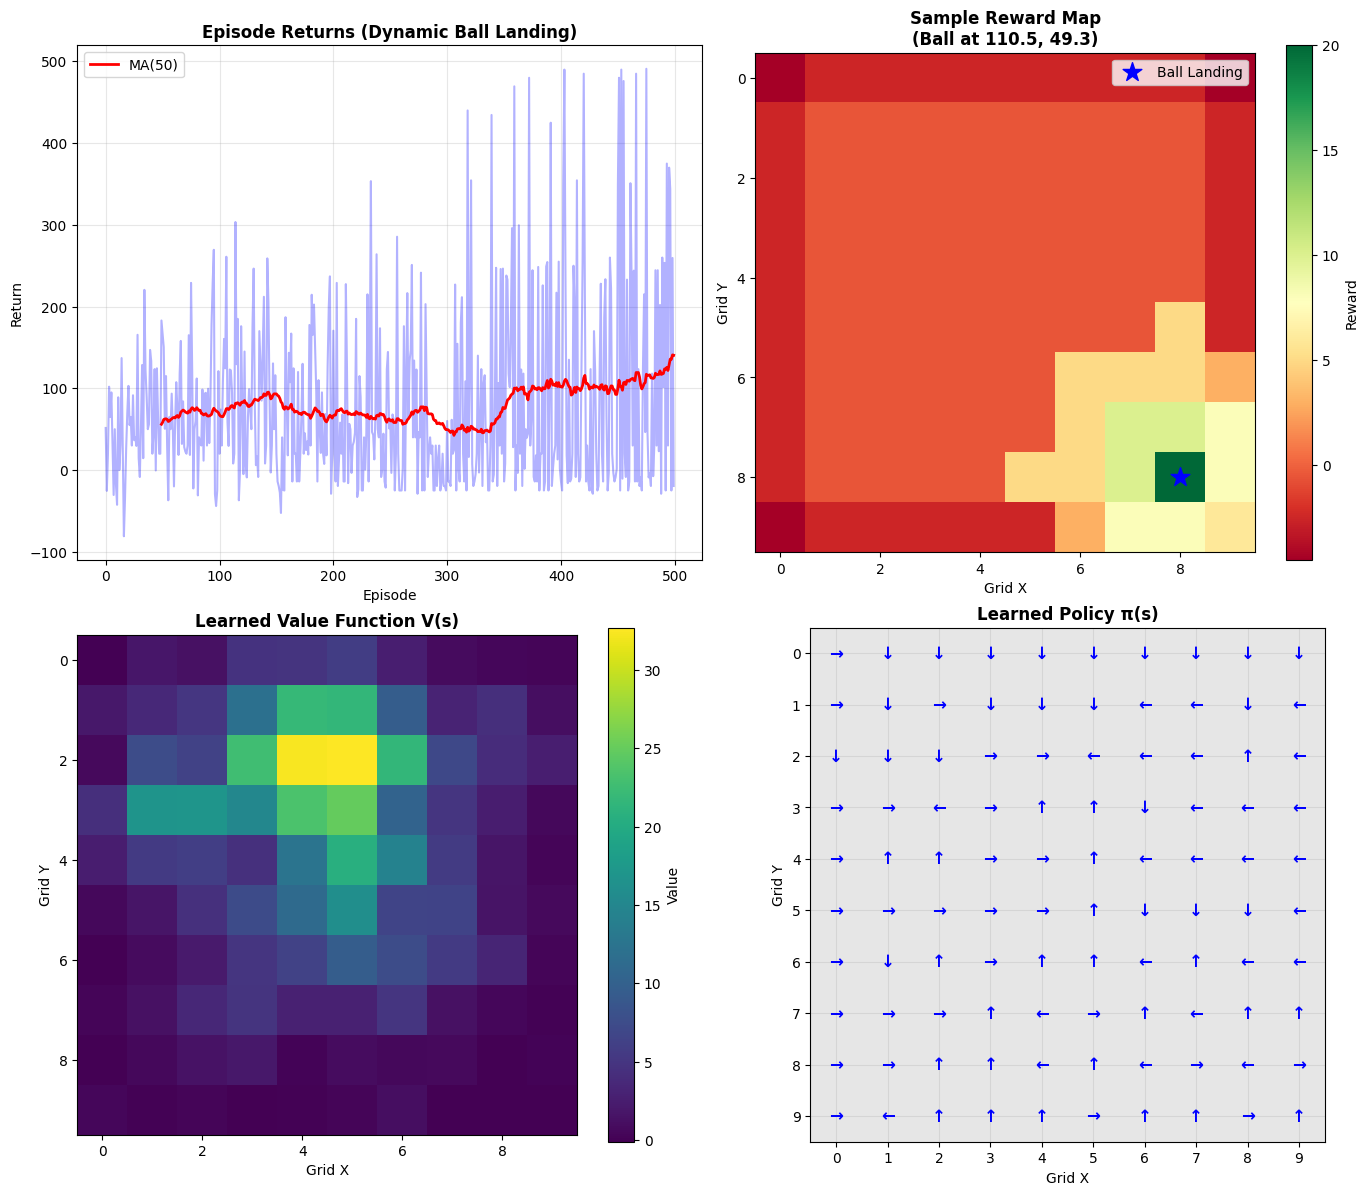

[20:20:20] RL visualization saved


In [33]:
# =============================================================================
# STEP 9.4: VISUALIZE RL RESULTS
# Source: Project 5 (Reinforcement Learning)
# Component: Policy and Learning Curve Visualization
# =============================================================================

log("Visualizing RL results...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Episode returns
ax = axes[0, 0]
ax.plot(episode_returns, 'b-', alpha=0.3)
window = 50
ma = np.convolve(episode_returns, np.ones(window)/window, mode='valid')
ax.plot(range(window-1, len(episode_returns)), ma, 'r-', linewidth=2, label=f'MA({window})')
ax.set_xlabel('Episode')
ax.set_ylabel('Return')
ax.set_title('Episode Returns (Dynamic Ball Landing)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Sample reward map (last ball landing used)
ax = axes[0, 1]
im = ax.imshow(env.rewards, cmap='RdYlGn', origin='upper')
ax.scatter(env.ball_grid_pos[1], env.ball_grid_pos[0], c='blue', s=200, marker='*',
           label='Ball Landing', zorder=5)
ax.set_title(f'Sample Reward Map\n(Ball at {ball_land_x:.1f}, {ball_land_y:.1f})', fontweight='bold')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
plt.colorbar(im, ax=ax, label='Reward')
ax.legend()

# 3. Value function
ax = axes[1, 0]
value_grid = agent.get_value().reshape(env.grid_size, env.grid_size)
im = ax.imshow(value_grid, cmap='viridis', origin='upper')
ax.set_title('Learned Value Function V(s)', fontweight='bold')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
plt.colorbar(im, ax=ax, label='Value')

# 4. Policy arrows
ax = axes[1, 1]
policy = agent.get_policy().reshape(env.grid_size, env.grid_size)
ax.imshow(np.ones((env.grid_size, env.grid_size)) * 0.9, cmap='gray', vmin=0, vmax=1, origin='upper')
arrows = ['↑', '↓', '←', '→']
for i in range(env.grid_size):
    for j in range(env.grid_size):
        ax.text(j, i, arrows[policy[i,j]], ha='center', va='center', fontsize=12, fontweight='bold', color='blue')
ax.set_title('Learned Policy π(s)', fontweight='bold')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
ax.set_xticks(range(env.grid_size))
ax.set_yticks(range(env.grid_size))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/artifacts/rl_dynamic_results.png", dpi=150, bbox_inches='tight')
plt.show()

log("RL visualization saved")


In [34]:
# =============================================================================
# STEP 9.5: TEST RL AGENT ON UNSEEN BALL LANDINGS
# Source: Project 5 (Reinforcement Learning)
# Component: Test Evaluation
# Purpose: Evaluate learned policy on test set ball landing positions
# =============================================================================

log("Testing RL agent on unseen ball landing positions...")

test_returns = []
test_goal_reached = 0

for i in range(len(ball_test)):
    ball_land_x, ball_land_y = ball_test[i]
    start_x, start_y = X_test[i, 0, 0], X_test[i, 0, 1]

    env.set_ball_landing(ball_land_x, ball_land_y)
    state = env.reset(start_x, start_y)

    episode_return = 0

    # Use greedy policy (no exploration)
    for step in range(rl_config['max_steps']):
        action = np.argmax(agent.Q[state])  # Greedy
        next_state, reward, done = env.step(action)
        episode_return += reward
        state = next_state
        if done:
            test_goal_reached += 1
            break

    test_returns.append(episode_return)

print(f"\nRL Test Results (on {len(ball_test)} unseen plays):")
print(f"  Average Return: {np.mean(test_returns):.2f}")
print(f"  Goal Reach Rate: {test_goal_reached/len(ball_test):.1%}")
print(f"  Max Return: {max(test_returns):.2f}")
print(f"  Min Return: {min(test_returns):.2f}")

RUN_LOGGER.log('rl', 'test_avg_return', np.mean(test_returns), notes='test_set')
RUN_LOGGER.log('rl', 'test_goal_rate', test_goal_reached/len(ball_test), notes='test_set')


[20:20:20] Testing RL agent on unseen ball landing positions...

RL Test Results (on 91 unseen plays):
  Average Return: 120.93
  Goal Reach Rate: 12.1%
  Max Return: 500.00
  Min Return: -25.00


---
## Step 10: Results Summary & Report Generation
**Source:** Project 5 (New)  
**Component:** Final Aggregation  
**Purpose:** Compile all results, save models, generate final report


In [35]:
# =============================================================================
# STEP 10.1: FINAL COMPARISON TABLE
# Source: Project 5 (Results)
# Component: Model Comparison
# Purpose: Side-by-side comparison of all models
# =============================================================================

log("Generating final comparison...")

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                           CLASSIFICATION RESULTS                            │
├─────────────────────────┬──────────┬──────────┬──────────┬─────────────────┤
│ Model                   │ Accuracy │ F1 Score │ ROC-AUC  │ Latency (ms)    │
├─────────────────────────┼──────────┼──────────┼──────────┼─────────────────┤
│ {best_classical_name:<23} │ {test_metrics_classical['accuracy']:.4f}   │ {test_metrics_classical['f1']:.4f}   │ {test_metrics_classical['roc_auc']:.4f}   │ {test_metrics_classical['latency_ms']:.2f}            │
│ MLP (Project 3)         │ {test_metrics_mlp['accuracy']:.4f}   │ {test_metrics_mlp['f1']:.4f}   │ {test_metrics_mlp['roc_auc']:.4f}   │ {test_metrics_mlp['latency_ms']:.2f}            │
│ LSTM (Project 4)        │ {lstm_results['class_accuracy']:.4f}   │ {lstm_results['class_f1']:.4f}   │ -        │ {lstm_results['latency_ms']:.2f}           │
│ Transformer (Project 4) │ {transformer_results['class_accuracy']:.4f}   │ {transformer_results['class_f1']:.4f}   │ -        │ {transformer_results['latency_ms']:.2f}           │
└─────────────────────────┴──────────┴──────────┴──────────┴─────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                        TRAJECTORY PREDICTION RESULTS                        │
├─────────────────────────┬─────────────────┬─────────────────┬───────────────┤
│ Model                   │ Mean L2 (yards) │ Final L2 (yards)│ Latency (ms)  │
├─────────────────────────┼─────────────────┼─────────────────┼───────────────┤
│ LSTM (Project 4)        │ {lstm_results['mean_l2']:.4f}          │ {lstm_results['final_l2']:.4f}          │ {lstm_results['latency_ms']:.2f}          │
│ Transformer (Project 4) │ {transformer_results['mean_l2']:.4f}          │ {transformer_results['final_l2']:.4f}          │ {transformer_results['latency_ms']:.2f}          │
└─────────────────────────┴─────────────────┴─────────────────┴───────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                              RL RESULTS                                     │
├─────────────────────────┬─────────────────┬─────────────────────────────────┤
│ Metric                  │ Training        │ Test                            │
├─────────────────────────┼─────────────────┼─────────────────────────────────┤
│ Average Return          │ {np.mean(episode_returns[-100:]):.2f}            │ {np.mean(test_returns):.2f}                            │
│ Goal Reach Rate         │ {episodes_reaching_goal/rl_config['episodes']:.1%}             │ {test_goal_reached/len(ball_test):.1%}                            │
└─────────────────────────┴─────────────────┴─────────────────────────────────┘
""")


[20:20:20] Generating final comparison...

FINAL MODEL COMPARISON

┌─────────────────────────────────────────────────────────────────────────────┐
│                           CLASSIFICATION RESULTS                            │
├─────────────────────────┬──────────┬──────────┬──────────┬─────────────────┤
│ Model                   │ Accuracy │ F1 Score │ ROC-AUC  │ Latency (ms)    │
├─────────────────────────┼──────────┼──────────┼──────────┼─────────────────┤
│ DecisionTree            │ 0.6484   │ 0.2381   │ 0.5088   │ 0.91            │
│ MLP (Project 3)         │ 0.8242   │ 0.4286   │ 0.6233   │ 7.20            │
│ LSTM (Project 4)        │ 0.8022   │ 0.0000   │ -        │ 31.07           │
│ Transformer (Project 4) │ 0.8022   │ 0.0000   │ -        │ 191.85           │
└─────────────────────────┴──────────┴──────────┴──────────┴─────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│                        TRAJECTORY PREDICTION RESULTS     

In [36]:
# =============================================================================
# STEP 10.2: SAVE ALL MODELS
# Source: Project 5 (Results)
# Component: Model Serialization
# =============================================================================

log("Saving models...")

import pickle

# Classical model
with open(f"{CONFIG['output_dir']}/models/classical_model.pkl", 'wb') as f:
    pickle.dump(best_classical, f)

# MLP
torch.save(mlp_model.state_dict(), f"{CONFIG['output_dir']}/models/mlp_model.pt")

# LSTM
torch.save(lstm_model.state_dict(), f"{CONFIG['output_dir']}/models/lstm_model.pt")

# Transformer
torch.save(transformer_model.state_dict(), f"{CONFIG['output_dir']}/models/transformer_model.pt")

# Scaler
with open(f"{CONFIG['output_dir']}/models/scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

# VAE Sampler
with open(f"{CONFIG['output_dir']}/models/vae_sampler.pkl", 'wb') as f:
    pickle.dump(vae_sampler, f)

# Q-table
np.save(f"{CONFIG['output_dir']}/models/q_table.npy", agent.Q)

print("All models saved!")
for f in os.listdir(f"{CONFIG['output_dir']}/models"):
    size = os.path.getsize(f"{CONFIG['output_dir']}/models/{f}")
    print(f"  {f}: {size/1024:.1f} KB")


[20:20:20] Saving models...
All models saved!
  vae_sampler.pkl: 1006.0 KB
  scaler.pkl: 0.7 KB
  lstm_model.pt: 413.7 KB
  mlp_model.pt: 42.3 KB
  classical_model.pkl: 17.5 KB
  q_table.npy: 3.2 KB
  transformer_model.pt: 970.2 KB


In [37]:
# =============================================================================
# STEP 10.3: FINAL SUMMARY
# Source: Project 5 (Results)
# Component: Project Completion
# =============================================================================

log("="*70)
log("PROJECT 5 COMPLETE: Final Integrated System")
log("="*70)

# Count run log entries
with open(f"{CONFIG['output_dir']}/run_log.csv", 'r') as f:
    n_logs = len(f.readlines()) - 1

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        PROJECT 5 FINAL SUMMARY                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  COMPONENTS INTEGRATED:                                                      ║
║    ✓ Step 1-2: Setup & Data (Project 5 - New)                               ║
║    ✓ Step 3:   Classical ML - DT, RF, SMOTE (Projects 1-2)                  ║
║    ✓ Step 4:   Neural Network - MLP + MC Dropout (Project 3)                ║
║    ✓ Step 5:   Sequential - LSTM & Transformer (Project 4)                  ║
║    ✓ Step 6:   Generative - VAE-style Augmentation (Project 5)              ║
║    ✓ Step 7:   MLOps & Ethics - Logging, Model Cards (Project 5)            ║
║    ✓ Step 8:   Graph - Link Prediction (Project 5)                          ║
║    ✓ Step 9:   RL - Q-Learning with Dynamic Ball Landing (Project 5)        ║
║    ✓ Step 10:  Results Summary (Project 5)                                  ║
║                                                                              ║
║  ACHIEVEMENT: 🏅 STRETCH GOAL                                                ║
║    ✓ Both Generative AND Graph                                              ║
║    ✓ Both RL AND MLOps                                                      ║
║                                                                              ║
║  ARTIFACTS:                                                                  ║
║    - Run log entries: {n_logs}                                                      ║
║    - Models saved: 7                                                         ║
║    - Model cards: 3                                                          ║
║    - Ethics documentation: 1                                                 ║
║                                                                              ║
║  REPRODUCIBILITY:                                                            ║
║    - Seed: {SEED}                                                               ║
║    - Data hash: {RUN_LOGGER.data_hash}                                            ║
║    - Config hash: {RUN_LOGGER.config_hash}                                        ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


[20:20:20] ======================================================================
[20:20:20] PROJECT 5 COMPLETE: Final Integrated System
[20:20:20] ======================================================================

╔══════════════════════════════════════════════════════════════════════════════╗
║                        PROJECT 5 FINAL SUMMARY                               ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  COMPONENTS INTEGRATED:                                                      ║
║    ✓ Step 1-2: Setup & Data (Project 5 - New)                               ║
║    ✓ Step 3:   Classical ML - DT, RF, SMOTE (Projects 1-2)                  ║
║    ✓ Step 4:   Neural Network - MLP + MC Dropout (Project 3)                ║
║    ✓ Step 5:   Sequential - LSTM & Transformer (Project 4)                  ║
║    ✓ Step 6:   Generative - VAE-style Augmentation (P